In [1]:
import itertools
import pandas as pd
import numpy as np
from random import gauss, shuffle

from sklearn.metrics import (mean_absolute_percentage_error, mean_squared_error, accuracy_score, roc_auc_score)

from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor, LGBMClassifier

import os
from  datetime import datetime, timedelta
import gc, copy

# from gensim.models import Word2Vec

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import warnings
warnings.simplefilter(action='ignore', category= FutureWarning)

In [2]:
# ## Mount drive
# from google.colab import drive
# drive.mount('/content/drive/')

In [2]:
# raw_data_dir = "/content/drive/MyDrive/m5_forecasting/original"
raw_data_dir = "../dataset/raw/"

sales_df = pd.read_csv(raw_data_dir+'sales_train.csv')
calendar_df = pd.read_csv(raw_data_dir+'calendar.csv')
prices_df = pd.read_csv(raw_data_dir+'sell_prices.csv')

In [3]:

class FeatureExtractor:
    """
    Extracts features for demand forecasting and inventory risk modeling.

    Supports:
    - demand (sales)
    - stockout risk
    - sell-through rate
    - overstock risk
    """

    EVENT_CATEGORIES = ["Sporting", "Cultural", "National", "Religious", "None"]
    KEY_EVENTS = [
        "ValentinesDay", "Easter", "Christmas", "SuperBowl",
        "IndependenceDay", "Thanksgiving", "NewYear", "Mother's day", "None"
    ]
    LAGS = [7, 14, 28]
    ROLLING_WINDOWS = [7, 14, 28]

    def __init__(self, calendar_df, sell_prices_df, sales_df, task_type="demand", stock_threshold=10, initial_stock=1000):
        self.calendar = calendar_df.copy()
        self.prices = sell_prices_df.copy()
        self.sales = sales_df.copy()
        self.task_type = task_type
        self.stock_threshold = stock_threshold
        self.initial_stock = initial_stock



    @staticmethod
    def assign_season(month):
        if month in [12, 1, 2]: return "Winter"
        if month in [3, 4, 5]: return "Spring"
        if month in [6, 7, 8]: return "Summer"
        return "Fall"

    @staticmethod
    def reduce_mem_usage(df):
        for col in df.columns:
            col_type = df[col].dtype
            if pd.api.types.is_numeric_dtype(col_type):
                c_min = df[col].min()
                c_max = df[col].max()
                if pd.api.types.is_integer_dtype(col_type):
                    if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                else:
                    if c_min >= np.finfo(np.float16).min and c_max <= np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min >= np.finfo(np.float32).min and c_max <= np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
            elif pd.api.types.is_object_dtype(col_type):
                df[col] = df[col].astype("category")
        return df

    def prepare_features(self):

        ## RAM
        self.sales = self.reduce_mem_usage(self.sales)
        self.calendar = self.reduce_mem_usage(self.calendar)
        self.prices = self.reduce_mem_usage(self.prices)

        id_vars = ["item_id", "dept_id", "cat_id"]
        value_vars = [col for col in self.sales.columns if col.startswith("d_")]
        sales_long = self.sales.melt(id_vars=id_vars, value_vars=value_vars, var_name="d", value_name="sales")

        df = sales_long.merge(self.calendar, on="d", how="left")

        df = df.merge(self.prices, on=["item_id", "wm_yr_wk"], how="left")

        ## RAM
        gc.collect()

        df.sort_values(by=["item_id", "date"], inplace=True)
        df["sell_price"] = df.groupby("item_id")["sell_price"].ffill()

        for lag in self.LAGS:
            df[f"lag_{lag}"] = df.groupby("item_id")["sales"].shift(lag)

        for window in self.ROLLING_WINDOWS:
            df[f"rolling_mean_{window}"] = df.groupby("item_id")["sales"].transform(
                lambda x: x.shift(1).rolling(window).mean()).astype("float32")

            df[f"rolling_std_{window}"] = df.groupby("item_id")["sales"].transform(
                lambda x: x.shift(1).rolling(window).std()).astype("float32")


        # df["expanding_mean"] = df.groupby("item_id")["sales"].transform(lambda x: x.shift(1).expanding().mean())
        df["price_change_pct"] = df.groupby("item_id")["sell_price"].pct_change()
        df["rolling_price_std_4w"] = df.groupby("item_id")["sell_price"].transform(lambda x: x.rolling(28).std())

        # df["day_of_week"] = df["date"].dt.weekday
        # df = pd.get_dummies(df, columns=["day_of_week"], prefix="dow")
        df["day_of_week"] = df["date"].dt.weekday.astype("int8")  # no one-hot
        df["week_of_year"] = df["date"].dt.isocalendar().week.astype("int")
        df["quarter"] = df["date"].dt.quarter
        df["month"] = df["date"].dt.month
        df["year"] = df["date"].dt.year
        df["season"] = df["month"].apply(self.assign_season)
        df = pd.get_dummies(df, columns=["season"], prefix="season")

        for col in ["event_type_1", "event_type_2", "event_name_1", "event_name_2"]:
          if df[col].dtype.name == "category":
              if "None" not in df[col].cat.categories:
                  df[col] = df[col].cat.add_categories(["None"])
          df[col] = df[col].fillna("None")

        for cat in self.EVENT_CATEGORIES:
            df[f"is_{cat.lower()}"] = ((df["event_type_1"] == cat) | (df["event_type_2"] == cat)).astype("int")
        df["has_event"] = ((df["event_type_1"] != "None") | (df["event_type_2"] != "None")).astype("int")

        for event in self.KEY_EVENTS:
            safe_event = event.lower().replace(" ", "_").replace("'", "").replace("-", "").replace(".", "")
            col = f"is_{safe_event}"
            df[col] = ((df["event_name_1"] == event) | (df["event_name_2"] == event)).astype("int")

        #New features for target outputs
        df["cumulative_sales"] = df.groupby("item_id")["sales"].cumsum()
        df["stock_level"] = self.initial_stock - df["cumulative_sales"]
        df["stockout_risk"] = (df["stock_level"] <= self.stock_threshold).astype(int)
        df["sell_through_7d"] = (
            df.groupby("item_id")["sales"].transform(lambda x: x.shift(-1).rolling(7).sum()) / df["stock_level"]
        ).clip(0, 1).fillna(0)
        df["rolling_demand_28d"] = df.groupby("item_id")["sales"].transform(lambda x: x.shift(1).rolling(28).sum())
        df["overstock_risk"] = (df["stock_level"] > 3 * df["rolling_demand_28d"]).astype(int)

        df.drop(columns=["d", "wm_yr_wk", "event_name_1", "event_name_2", "weekday", "date"], inplace=True, errors="ignore")

        df = self.reduce_mem_usage(df)
        return df


In [4]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split

def train_model(X, y, model_type="regression"):
    # Split into train/valid sets
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create LightGBM datasets
    lgb_train = lgb.Dataset(X_train, label=y_train)
    lgb_valid = lgb.Dataset(X_valid, label=y_valid, reference=lgb_train)

    # Set params
    if model_type == "regression":
        params = {
            'objective': 'regression',
            'metric': 'rmse',
            'learning_rate': 0.075,
            'num_leaves': 64,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'bagging_freq': 1,
            'verbosity': -1,
        }
    else:
        params = {
            'objective': 'binary',
            'metric': 'binary_logloss',
            'learning_rate': 0.075,
            'num_leaves': 64,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'bagging_freq': 1,
            'verbosity': -1,
        }

    # Train
    model = lgb.train(
        params,
        lgb_train,
        valid_sets=[lgb_train, lgb_valid],
        num_boost_round=1000,
        callbacks=[
            lgb.early_stopping(stopping_rounds=50),
            lgb.log_evaluation(period=100)
        ]
    )

    return model

def get_preds(model, X, col_name):
    preds = model.predict(X)
    if preds.ndim > 1: preds = preds[:, 1]
    return pd.Series(preds, index=X.index, name=col_name)


In [5]:
calendar_df["date"] = pd.to_datetime(calendar_df["date"])
calendar_df.drop(columns=[col for col in calendar_df.columns if "snap" in col], errors="ignore", inplace=True)

## RAM
keep_pct = 0.8  # keep last 50% of days


# Determine which days to keep
day_cols = [col for col in sales_df.columns if col.startswith("d_")]
num_keep = int(len(day_cols) * keep_pct)
keep_days = day_cols[-num_keep:]  # last N% of days

# Subset the sales data
sales_df = sales_df[["item_id", "dept_id", "cat_id"] + keep_days]

# Filter calendar and prices accordingly
calendar_df = calendar_df[calendar_df["d"].isin(keep_days)]
remaining_wm_yr_wks = calendar_df["wm_yr_wk"].unique()
prices_df = prices_df[prices_df["wm_yr_wk"].isin(remaining_wm_yr_wks)]


# 1. Prepare base data for all tasks
fe = FeatureExtractor(calendar_df, prices_df, sales_df, task_type="stockout")
df = fe.prepare_features()
df = df.dropna(subset=["sales"])

outputs = {}

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2329436 entries, 1612 to 2327998
Data columns (total 48 columns):
 #   Column                Dtype   
---  ------                -----   
 0   item_id               category
 1   dept_id               category
 2   cat_id                category
 3   sales                 int16   
 4   wday                  int8    
 5   month                 int8    
 6   year                  int16   
 7   event_type_1          category
 8   event_type_2          category
 9   sell_price            float16 
 10  lag_7                 float16 
 11  lag_14                float16 
 12  lag_28                float16 
 13  rolling_mean_7        float16 
 14  rolling_std_7         float16 
 15  rolling_mean_14       float16 
 16  rolling_std_14        float16 
 17  rolling_mean_28       float16 
 18  rolling_std_28        float16 
 19  price_change_pct      float16 
 20  rolling_price_std_4w  float16 
 21  day_of_week           int8    
 22  week_of_year        

In [ ]:
# Save df
# df.to_csv("../dataset/processed/lgbm_features.csv", index=False)

In [7]:
# Create base features
X_base = df.drop(columns=["sales", "cumulative_sales", "stock_level", "stockout_risk",
                          "sell_through_7d", "overstock_risk", "rolling_demand_28d"], errors="ignore")


In [8]:
# 1. Log Demand
# y_demand = df["sales"]
y_demand = np.log1p(df["sales"])
m_demand = train_model(X_base, y_demand, "regression")
outputs["predicted_demand"] = get_preds(m_demand, X_base, "predicted_demand")


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.498818	valid_1's rmse: 0.507657
[200]	training's rmse: 0.492401	valid_1's rmse: 0.505596
[300]	training's rmse: 0.489588	valid_1's rmse: 0.504969
[400]	training's rmse: 0.487521	valid_1's rmse: 0.504522
[500]	training's rmse: 0.485808	valid_1's rmse: 0.504219
[600]	training's rmse: 0.484284	valid_1's rmse: 0.504052
[700]	training's rmse: 0.482936	valid_1's rmse: 0.503859
[800]	training's rmse: 0.481651	valid_1's rmse: 0.503721
[900]	training's rmse: 0.480406	valid_1's rmse: 0.503548
[1000]	training's rmse: 0.479284	valid_1's rmse: 0.503477
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.479284	valid_1's rmse: 0.503477


In [10]:
# 2. Log Stockout
y_stockout = df["stockout_risk"]
m_stockout = train_model(X_base, y_stockout, "classification")
outputs["predicted_stockout_risk"] = get_preds(m_stockout, X_base, "predicted_stockout_risk")

Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0163362	valid_1's binary_logloss: 0.0173903
[200]	training's binary_logloss: 0.00623612	valid_1's binary_logloss: 0.00832465
[300]	training's binary_logloss: 0.00368658	valid_1's binary_logloss: 0.00638046
[400]	training's binary_logloss: 0.00252871	valid_1's binary_logloss: 0.00528488
[500]	training's binary_logloss: 0.00185514	valid_1's binary_logloss: 0.00467813
[600]	training's binary_logloss: 0.00142573	valid_1's binary_logloss: 0.00432709
[700]	training's binary_logloss: 0.00112426	valid_1's binary_logloss: 0.00404685
[800]	training's binary_logloss: 0.000904639	valid_1's binary_logloss: 0.00385059
[900]	training's binary_logloss: 0.000740727	valid_1's binary_logloss: 0.00370135
[1000]	training's binary_logloss: 0.000607346	valid_1's binary_logloss: 0.00356863
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000607346	valid_1's binary_logloss: 0.00356

In [11]:
res_df = df[
    ["item_id", "dept_id", "cat_id", "month", "week_of_year", "quarter", "has_event"]
].copy()
for name, series in outputs.items():
    res_df[name] = series

# Save results
res_df.to_csv("../dataset/processed/lgbm_predictions.csv", index=False)
del res_df

In [12]:
# 3. Sell-through
# y_sell = df["sell_through_7d"]
y_sell = np.log1p(df["sell_through_7d"])
m_sell = train_model(X_base, y_sell, "regression")
outputs["predicted_sell_through"] = get_preds(m_sell, X_base, "predicted_sell_through")

Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.0432377	valid_1's rmse: 0.0443588
[200]	training's rmse: 0.0399756	valid_1's rmse: 0.0417099
[300]	training's rmse: 0.0374234	valid_1's rmse: 0.0397075
[400]	training's rmse: 0.035355	valid_1's rmse: 0.0380972
[500]	training's rmse: 0.0337052	valid_1's rmse: 0.0368325
[600]	training's rmse: 0.0321568	valid_1's rmse: 0.0356398
[700]	training's rmse: 0.0308378	valid_1's rmse: 0.034592
[800]	training's rmse: 0.0297581	valid_1's rmse: 0.0337805
[900]	training's rmse: 0.0287383	valid_1's rmse: 0.0330262
[1000]	training's rmse: 0.0278184	valid_1's rmse: 0.03231
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.0278184	valid_1's rmse: 0.03231


In [13]:
# 4. Overstock
y_overstock = df["overstock_risk"]
m_over = train_model(X_base, y_overstock, "classification")
outputs["predicted_overstock_risk"] = get_preds(m_over, X_base, "predicted_overstock_risk")




Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.0185919	valid_1's binary_logloss: 0.0196956
[200]	training's binary_logloss: 0.00839527	valid_1's binary_logloss: 0.0100827
Early stopping, best iteration is:
[217]	training's binary_logloss: 0.00748113	valid_1's binary_logloss: 0.00948652


In [ ]:
# Combine outputs
result_df = df[["item_id", "dept_id", "cat_id", "month", "week_of_year", "quarter", "has_event"]].copy()
for name, series in outputs.items():
    result_df[name] = series

result_df["risk_score"] = result_df["predicted_stockout_risk"] + result_df["predicted_overstock_risk"]



In [15]:
# save models
import joblib
model_dir = "../models/"

os.makedirs(model_dir, exist_ok=True)
joblib.dump(m_demand, os.path.join(model_dir, "m_demand.pkl"))
joblib.dump(m_stockout, os.path.join(model_dir, "m_stockout.pkl"))
joblib.dump(m_sell, os.path.join(model_dir, "m_sellthrough.pkl"))
joblib.dump(m_over, os.path.join(model_dir, "m_overstock.pkl"))

# Save final results
result_df.to_csv("../dataset/processed/lgbm_final_predictions.csv", index=False)

In [ ]:
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8))

print("Demand Regression:")
print("  SMAPE:", smape(y_demand, outputs["predicted_demand"]))
print("  RMSE:", np.sqrt(mean_squared_error(y_demand, outputs["predicted_demand"])))

print("\n Stockout Classification:")
print("  Accuracy:", accuracy_score(y_stockout, (outputs["predicted_stockout_risk"] > 0.5).astype(int)))
print("  ROC AUC:", roc_auc_score(y_stockout, outputs["predicted_stockout_risk"]))

print("\n Sell Regression Model:")
print("  SMAPE:", smape(y_sell, outputs["predicted_sell_through"]))
print("  RMSE:", np.sqrt(mean_squared_error(y_sell, outputs["predicted_sell_through"])))

print("\n Overstock Classification:")
print("  Accuracy:", accuracy_score(y_overstock, (outputs["predicted_overstock_risk"] > 0.5).astype(int)))
print("  ROC AUC:", roc_auc_score(y_overstock, outputs["predicted_overstock_risk"]))


🔍 Demand Model:
  SMAPE: 130.88653296814846
  RMSE: 2.719560400965673

🔍 Stockout Model:
  Accuracy: 0.9965871567194806
  ROC AUC: 0.9939313477917234

🔍 Sell-through Model:
  SMAPE: 101.06168312155552
  RMSE: 0.06299529872175248

🔍 Overstock Model:
  Accuracy: 0.996045394679227
  ROC AUC: 0.9946580876432672


In [ ]:
# View output for inspection
result_df.head()


,item_id,dept_id,cat_id,month,week_of_year,quarter,has_event,predicted_demand,predicted_stockout_risk,predicted_sell_through,predicted_overstock_risk,risk_score
1612,FOODS_1_001,FOODS_1,FOODS,3,12,1,0,1.663309,0,0.001504,0,0
4661,FOODS_1_001,FOODS_1,FOODS,3,13,1,0,1.178166,0,0.001504,0,0
7710,FOODS_1_001,FOODS_1,FOODS,3,13,1,0,1.158545,0,0.001504,0,0
10759,FOODS_1_001,FOODS_1,FOODS,3,13,1,0,1.140020,0,0.001504,0,0
13808,FOODS_1_001,FOODS_1,FOODS,3,13,1,0,1.140020,0,0.001504,0,0


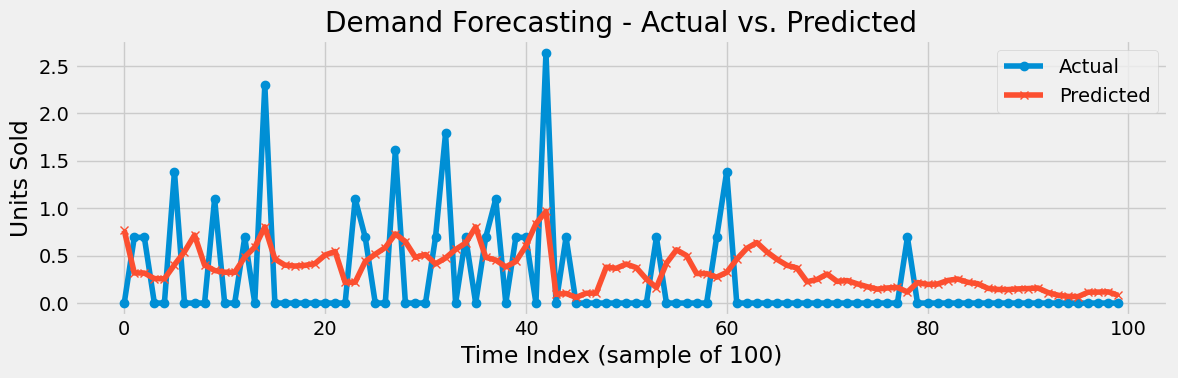

In [19]:
# Plot: Actual vs. Predicted Demand (first 100 rows)
plt.figure(figsize=(12, 4))
plt.plot(y_demand[:100].values, label="Actual", marker='o')
plt.plot(np.expm1(outputs["predicted_demand"][:100]).values, label="Predicted", marker='x')
plt.title("Demand Forecasting - Actual vs. Predicted")
plt.xlabel("Time Index (sample of 100)")
plt.ylabel("Units Sold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


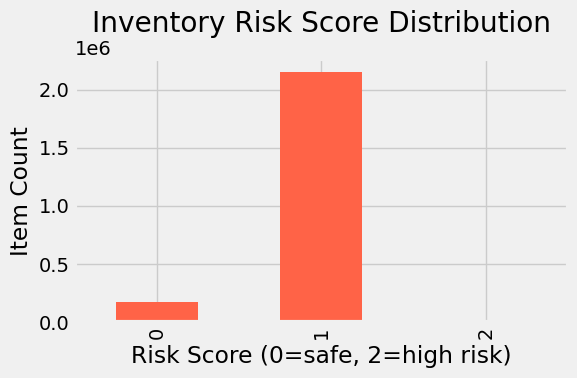

In [21]:
# Risk Score = sum of predicted stockout + overstock flags
result_df["risk_score_flag"] = (result_df["predicted_stockout_risk"] > 0.5).astype(int) + \
                   (result_df["predicted_overstock_risk"] > 0.5).astype(int)

result_df["risk_score_flag"].value_counts().sort_index().plot(
    kind="bar", color="tomato", figsize=(6, 4)
)
plt.title("Inventory Risk Score Distribution")
plt.xlabel("Risk Score (0=safe, 2=high risk)")
plt.ylabel("Item Count")
plt.grid(True)
plt.tight_layout()
plt.show()


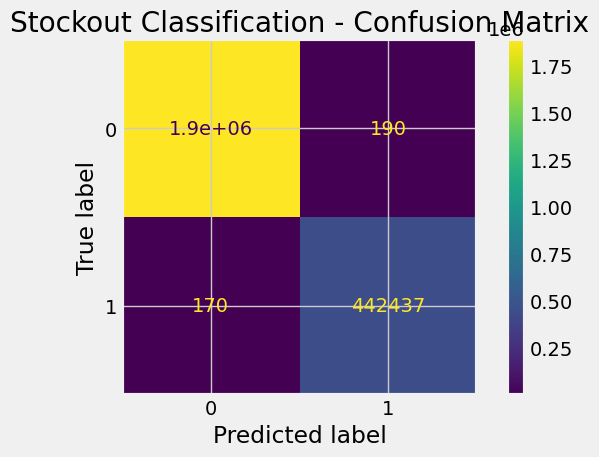

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay

y_true = df["stockout_risk"]
y_pred = (result_df["predicted_stockout_risk"] > 0.5).astype(int)

ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
plt.title("Stockout Classification - Confusion Matrix")
plt.tight_layout()
plt.show()


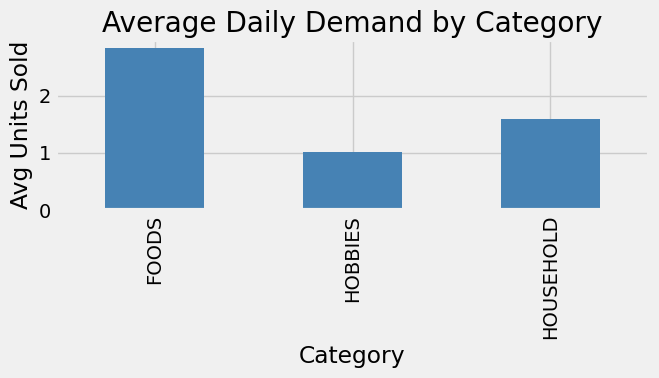

In [26]:
df.groupby("cat_id")["sales"].mean().plot(
    kind="bar", color="steelblue", figsize=(7, 4)
)
plt.title("Average Daily Demand by Category")
plt.xlabel("Category")
plt.ylabel("Avg Units Sold")
plt.grid(True)
plt.tight_layout()
plt.show()


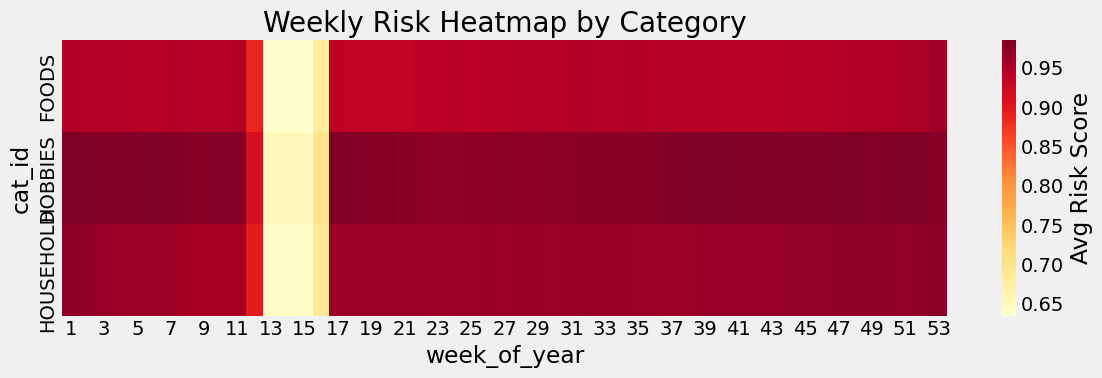

In [29]:
import seaborn as sns

pivot = result_df.pivot_table(
    index="cat_id", columns="week_of_year", values="risk_score", aggfunc="mean"
)

plt.figure(figsize=(12, 4))
sns.heatmap(pivot, cmap="YlOrRd", cbar_kws={'label': 'Avg Risk Score'})
plt.title("Weekly Risk Heatmap by Category")
plt.tight_layout()
plt.show()
